# Efficient Neural Causal Discovery without Acyclicity Constraints

This notebook is intended to give an overview of the functionalities in this repository. We recommend to go through this notebook if you are interested in working with this repository.

## Preparation

This part is only needed when you are running on Google Colab. We clone the repo to have access to the python files. In case you run this notebook locally, this step will be automatically skipped.

In [ ]:
import os
import sys

if not os.path.isdir('causal_graphs/'):
    print("Cloning the repository...")
    !git clone https://github.com/phlippe/ENCO
    sys.path.append('ENCO/')

For nicer visualizations, we import matplotlib with inline arguments. Additionally, we import PyTorch and Numpy on which the ENCO implementation is based on.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

import torch
import numpy as np

## Causal Graphs

First, we take a look at how we can generate causal graphs and interact with them. All functionalities for this purpose have been summarized in the folder `causal_graphs`, and we import the most important functions below.

In [2]:
from causal_graphs.graph_definition import CausalDAG  # Base class of causal graphs
from causal_graphs.graph_generation import generate_categorical_graph, get_graph_func, generate_continous_graph  # Functions for generating new graphs
from causal_graphs.graph_visualization import visualize_graph  # Plotting the graph in matplotlib

Every graph is represented as a `CausalDAG` object that contains a list of variables and an adjacency matrix/edge list to represent the graph structure. The conditional distributions are part of the variable objects. To sample a new data point, we iterate through the variables in the causal order and sample one by one. To demonstrate this, let us first generate an arbitrary graph. This can be done with the `generate_categorical_graph` function, and we can specify the desired graph structure with `get_graph_func`:

In [3]:
graph = generate_categorical_graph(num_vars=8, 
                                   min_categs=10,
                                   max_categs=10,
                                   graph_func=get_graph_func('random'),
                                   edge_prob=0.4,
                                   seed=42)

In [4]:
graph = generate_continous_graph(num_vars=8,
                                 is_add_noise=False,
                                 nn_size='small', 
                                 base_dist='normal',
                                 graph_func=get_graph_func('random'), 
                                 edge_prob=0.4, seed=42)

This function call creates a new graph with 8 variables, each having a distribution over 10 categories, and the graph structure is generated randomly by sampling an edge between any pair of variables with a probability of 0.4. The seed ensures that the graph generation is reproducible. To generate other graph structures, simply replace the string `'random'` by e.g. `'chain'` or `'jungle'`.

To get an intuition of what the graph actually looks like, we can print it:

In [5]:
print(graph)

CausalDAG with 8 variables [D,E,G,H,C,F,A,B] and 10 edges:
D => E,G,B
E => H,C
G => C
H => F,A
C => A
A => B



The variables are named alphabetically, and we have 10 edges. The edges are listed below the first line, e.g., we have an edge from D to E, and an edge from D to G. Alternatively, we can also plot the graph with matplotlib: 

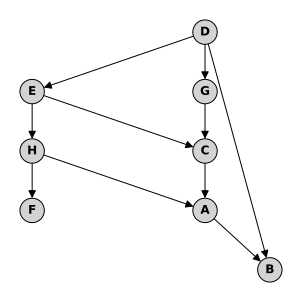

In [6]:
visualize_graph(graph, figsize=(4, 4), show_plot=True)

To sample from a graph, we use the function `CausalDAG.sample`:

In [7]:
graph.sample()

{'D': array([0.22232616], dtype=float32),
 'E': array([1.4062064], dtype=float32),
 'G': array([-2.7198381], dtype=float32),
 'H': array([0.7012233], dtype=float32),
 'C': array([1.4001391], dtype=float32),
 'F': array([2.3154678], dtype=float32),
 'A': array([-0.8946453], dtype=float32),
 'B': array([-3.4003797], dtype=float32)}

Sampling with interventions is supported by passing a dictionary with the intended interventions. The interventions can be imperfect, i.e. a new distribution, or perfect, i.e. constant values. We demonstrate here a perfect intervention on the variable C:

In [8]:
graph.sample(interventions={'D': np.array([50])})

{'D': array([50]),
 'E': array([25.040556], dtype=float32),
 'G': array([-21.310596], dtype=float32),
 'H': array([-0.19241673], dtype=float32),
 'C': array([-15.1306925], dtype=float32),
 'F': array([1.7672868], dtype=float32),
 'A': array([2.5652668], dtype=float32),
 'B': array([-5.810983], dtype=float32)}

Graphs can be saved and loaded with the function `save_to_file` and `CausalDAG.load_from_file`. To save the graph as a set of observational and interventional dataset, you can use the function `export_graph` from `graph_export.py`. We used this functionality to export the data to apply other causal discovery methods on. Graphs in the `.bif` format, as from the BnLearn repository, can be loaded via the function `load_graph_file` in `graph_real_world.py`.

In [9]:
graph

## Causal Discovery with ENCO

The graph objects explained above are used to implement the structure learning with ENCO in the folder `causal_discovery`. To run ENCO on such a graph, we simply need to create an `ENCO` object, and run the structure learning via the `discover_graph` function:

In [10]:
from causal_discovery.enco import ENCO

In [11]:
enco_module = ENCO(
    graph=graph, 
    use_flow_model=True,
    sample_size_inters=1000,
    sample_size_obs=1000,
    hidden_dims=[256, 256, 256],
    lambda_sparse=0.001
)
if torch.cuda.is_available():
    enco_module.to(torch.device('cuda:0'))

Creating dataset...
Dataset created in 0.01s
Sampling interventional data...
Done in 0.00s
Distribution fitting model:
DeepSigmoidalFlowModel(
  (condition_mlp): MultivarMLP(
    (layers): ModuleList(
      (0): InputMask()
      (1): MultivarLinear(input_dims=16, output_dims=256, extra_dims=[8])
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): MultivarLinear(input_dims=256, output_dims=256, extra_dims=[8])
      (4): LeakyReLU(negative_slope=0.01, inplace=True)
      (5): MultivarLinear(input_dims=256, output_dims=256, extra_dims=[8])
      (6): LeakyReLU(negative_slope=0.01, inplace=True)
      (7): MultivarLinear(input_dims=256, output_dims=240, extra_dims=[8])
    )
  )
  (flow): SigmoidFlow()
)
Dataset size:
- Observational: 1000
- Interventional: 1000


In [12]:
predicted_adj_matrix = enco_module.discover_graph(num_epochs=10)

Epoch loop:   0%|          | 0/10 [00:00<?, ?it/s]

Distribution fitting loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Graph fitting loop:   0%|          | 0/100 [00:00<?, ?it/s]

--- [EPOCH 1] ---
Graph - SHD: 19, Recall: 10.00%, Precision: 7.69% (TP=1,FP=12,FN=9,TN=34)
      -> FP: ancestors=4, descendants=5, confounders=3, independents=0
Theta - Orientation accuracy: 50.00% (TP=5,FN=5)


Distribution fitting loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Graph fitting loop:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

: 

After every epoch, the metrics of comparing the current prediction to the ground truth graph are printed out. In the case of the small graph we created above, ENCO finds the graph quite quickly. The return value is the predicted adjacency matrix, and can be passed to a new graph object if you want to visualize the prediction. Hyperparameters for the structure learning process can be passed to the ENCO object in the init-function. 

This completes the quick guide through the code. To run experiments on a larger scale, we recommend to use the python files provided in the `experiments` folder. Further, the commands to reproduce the experiments in the paper are provided in `experiments/run_scripts/`.

In [ ]:
predicted_adj_matrix

In [ ]:
enco_module.true_adj_matrix

In [ ]:
d = graph.sample(batch_size=100)

In [ ]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(d)

sns.pairplot(df, diag_kind='kde', kind='scatter')